In [6]:
import os 
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from pydantic import BaseModel,Field
from typing import Optional,Literal
from typing import TypedDict
load_dotenv()



GROQ_API_KEY = os.getenv("GROQ_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")


In [2]:
Model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",api_key=GOOGLE_API_KEY)
Model.invoke('What is 2+2?')

AIMessage(content='2+2 = 4', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--52d20312-1179-4576-b545-29fe44bb36e1-0', usage_metadata={'input_tokens': 8, 'output_tokens': 6, 'total_tokens': 33, 'input_token_details': {'cache_read': 0}})

In [7]:
# lets make a review replier which will check review is postive
# or negative,if its postive then simply thanks to the customer
# if its negative then we will check the problem , user tone like 
# anger, calm etc and urgency type .
# then based on it we will assist the user. 

In [ ]:
class SentimentSchema(BaseModel):
    sentiment  : Literal['positive','negative'] = Field(description="sentiment of the review")
    

In [35]:
class daignose_schema(BaseModel):
    issue_type :Literal["bug",'ux','performance','support','other'] = Field(description="the category of issue mentioned in the review")
    tone:Literal['normal','anger','calm',"other"]  = Field(description="The tone of the user from the review")
    urgency: Literal['low','medium','high'] =  Field(description="how urgency or the critical issue is.")
    

In [36]:
Model_01 = Model.with_structured_output(SentimentSchema)
Model_02 = Model.with_structured_output(daignose_schema)

In [26]:
review = "this phone is pathetic"
prompt = "what is review of the sentiment - this software is to good"
Model_01.invoke(prompt).sentiment

'positive'

In [34]:
class reviewState(TypedDict):
    review:str
    sentiment:Literal['positive','negative']
    daignosis:dict
    response:str



In [92]:
def find_sentiment(state: reviewState):
    review = state['review']
    prompt = f"For the following review, find the sentiment:\n{review}"
    result = Model_01.invoke(prompt)
    return {'sentiment': result}

def check_sentiment(state: reviewState) -> Literal['positive_response', 'diagnose']:
    if state['sentiment'].sentiment == 'positive':
        return 'positive_response'
    else:
        return 'diagnose'

def positive_response(state: reviewState):
    prompt = f"Write a warm thank-you message based on this review:\n- {state['review']}"
    positive_output = Model.invoke(prompt).content
    return {'response': positive_output}

def diagnose(state: reviewState):
    prompt = f"""Diagnose this negative review:\n- {state['review']}\nReturn issue_type, tone, and urgency."""
    neg_review = Model_02.invoke(prompt)
    return {'daignosis': neg_review.model_dump()}

def negative_response(state: reviewState):
    diagnosis = state['daignosis']
    prompt = f"""You are a support assistant.
The user had a {diagnosis['issue_type']}, issue sounded {diagnosis['tone']}, and urgency level {diagnosis['urgency']}.
Write a helpful empathetic message for the user. It should be simple and concise."""
    response = Model.invoke(prompt).content
    return {'response': response}


In [93]:
from langgraph.graph import StateGraph,START,END
graph = StateGraph(reviewState)
graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("diagnose", diagnose)
graph.add_node("negative_response", negative_response)

#edges
graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("diagnose", "negative_response")  
graph.add_edge("negative_response", END)

Workflow = graph.compile()


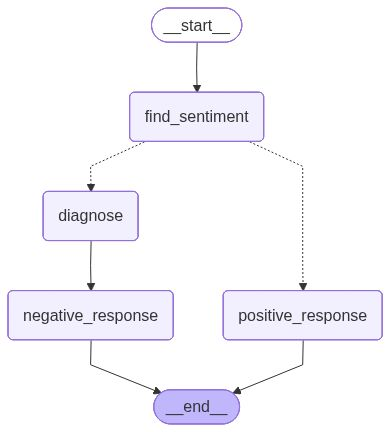

In [94]:
from IPython.display import Image, display
try:
    png_data = Workflow.get_graph().draw_mermaid_png()
    display(Image(data=png_data))
except Exception as e:
    raise ValueError(f"Error displaying graph image: {e}")


In [96]:
initial_state= {"review":"This product is pathetic ,i tied to login from last an hour but authetication screen is stuck"}
result=Workflow.invoke(initial_state)
print(result)

{'review': 'This product is pathetic ,i tied to login from last an hour but authetication screen is stuck', 'sentiment': SentimentSchema(sentiment='negative'), 'daignosis': {'issue_type': 'bug', 'tone': 'anger', 'urgency': 'high'}, 'response': "I'm so sorry to hear you've hit a bug – that sounds incredibly frustrating, and I understand this is urgent.\n\nPlease tell me more about what happened so I can help get this resolved for you as quickly as possible."}
